In [1]:
import cv2 as cv
import glob
import numpy as np

from IPython.display import display, Markdown
import matplotlib.pyplot as plt

from PIL import Image
from PIL.ExifTags import TAGS

from collections import defaultdict 


In [2]:
'''
Read images from folder
'''
images_paths = glob.glob("images/*.jpg")
# images_paths = glob.glob("images/cup/*.jpg")
images_paths.sort()
print(images_paths)

images = [cv.imread(img) for img in images_paths]

['images/B22.jpg', 'images/B23.jpg', 'images/B24.jpg', 'images/B25.jpg']


In [3]:
kp_images = []
sift = cv.SIFT_create()

kps = []
dess = []

for i, img in enumerate(images):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray,None)
    kps.append(kp)
    dess.append(des)
    kp_img = cv.drawKeypoints(img, kp, img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    cv.imwrite(f'sift_images/{i}.jpg',kp_img)

In [4]:
sift_images_paths = glob.glob("sift_images/*.jpg")
sift_images_paths.sort(reverse=True)
max_image_width = 300

markdown_content = '<div style="display: flex; flex-wrap: wrap;">'
for i, path in enumerate(sift_images_paths):
    img_html = f'<img src="{path}" alt="{i}" width="{max_image_width}px">'
    markdown_content += img_html
markdown_content += '</div>'
display(Markdown(markdown_content))

<div style="display: flex; flex-wrap: wrap;"><img src="sift_images/3.jpg" alt="0" width="300px"><img src="sift_images/2.jpg" alt="1" width="300px"><img src="sift_images/1.jpg" alt="2" width="300px"><img src="sift_images/0.jpg" alt="3" width="300px"></div>

In [16]:
matches = defaultdict(list)
good_matches = defaultdict(list)


# Create a BFMatcher with cross-check enabled
bf = cv.BFMatcher(crossCheck=True)

for i in range(len(images)-1):
    matches[f'{i+1}-{i+2}'] = bf.match(dess[i], dess[i+1])

for key, match_pair in matches.items():
    matches[key] = sorted(match_pair, key=lambda x: x.distance)
    print(f"Number of matches for {key}: {len(match_pair)}")
    
    
    

    
ratio_threshold = 4.5  # You can experiment with this threshold value
for key, match_pair in matches.items():
    curr_matches = []
    for match in match_pair:
        print(match_pair)
        if match.distance < ratio_threshold * match_pair[0].distance:
            curr_matches.append(match)
    good_matches[key] = curr_matches

for key, match_pair in good_matches.items():
    print(f"Number of good matches for {key}: {len(match_pair)}")
              

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[< cv2.DMatch 0x7f9f2c2b48b0>, < cv2.DMatch 0x7f9f2c2b49b0>, < cv2.DMatch 0x7f9f2c2b5cf0>, < cv2.DMatch 0x7f9f2c2b51b0>, < cv2.DMatch 0x7f9f2c2b5290>, < cv2.DMatch 0x7f9f2c2b51f0>, < cv2.DMatch 0x7f9f2c2b4e90>, < cv2.DMatch 0x7f9f2c2b63f0>, < cv2.DMatch 0x7f9f2c2b52b0>, < cv2.DMatch 0x7f9f2c2b5990>, < cv2.DMatch 0x7f9f2c2b1810>, < cv2.DMatch 0x7f9f2c2b5bd0>, < cv2.DMatch 0x7f9f2c2b4430>, < cv2.DMatch 0x7f9f2c2b5790>, < cv2.DMatch 0x7f9f2c2b4210>, < cv2.DMatch 0x7f9f2c2b6670>, < cv2.DMatch 0x7f9f2c2b63d0>, < cv2.DMatch 0x7f9f2c2b5030>, < cv2.DMatch 0x7f9f2c2b5490>, < cv2.DMatch 0x7f9f2c2b5050>, < cv2.DMatch 0x7f9f2c2b5c30>, < cv2.DMatch 0x7f9f2c2b4290>, < cv2.DMatch 0x7f9f2c2b1830>, < cv2.DMatch 0x7f9f2c2b1ad0>, < cv2.DMatch 0x7f9f2c2b46b0>, < cv2.DMatch 0x7f9f2c2b1a70>, < cv2.DMatch 0x7f9f2c2b3650>, < cv2.DMatch 0x7f9f2c2b44d0>, < cv2.DMatch 0x7f9f2c2b42b0>, < cv2.DMatch 0x7f9f2c2b37b0>, < cv2.DMatch 0x7f9f2c2b4d90>, < cv2.DMatch 0x7f9f2c2b55f0>, < cv2.DMatch 0x7f9f2c2b5370>, < cv2.DM

In [6]:
des1 = dess[0]
des2 = dess[1]

kp1 = kps[0]
kp2 = kps[1]


flann_matches = defaultdict(list)
flann_good_matches = defaultdict(list)
flann_good_matches_ind = defaultdict(list)




# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=100)
flann = cv.FlannBasedMatcher(index_params,search_params)

for i in range(len(images) - 1):
    matches = flann.knnMatch(dess[i],dess[i+1],k=2)
    flann_matches[f"{i+1}-{i+2}"] = matches

index = 0
for key, matches in flann_matches.items():
    pts1 = []
    pts2 = []
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.8*n.distance:
            pts2.append(kps[index+1][m.trainIdx].pt)
            pts1.append(kps[index][m.queryIdx].pt)
            flann_good_matches_ind[f"{index+1}-{index+2}"] = [pts1, pts2]
            flann_good_matches[f"{index+1}-{index+2}"].append(m)
    index += 1
# print(len(flann_good_matches['2-3'][0]) == len(flann_good_matches['2-3'][1]))

In [15]:
img1 = cv.imread('images/B22.jpg',cv.IMREAD_GRAYSCALE) # queryImage
img2 = cv.imread('images/B23.jpg',cv.IMREAD_GRAYSCALE) # trainImage
img3 = cv.imread('images/B24.jpg',cv.IMREAD_GRAYSCALE) # trainImage
img4 = cv.imread('images/B25.jpg',cv.IMREAD_GRAYSCALE) # trainImage

imgs_raw = [img1, img2, img3, img4]
imgs_matched = []


for i in range(len(flann_good_matches)):
    print(flann_good_matches[f'{i+1}-{i+2}'])
    imgs_matched.append(cv.drawMatches(imgs_raw[i], kps[i], imgs_raw[i+1], kps[i+1], flann_good_matches[f'{i+1}-{i+2}'][10:], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS))
    

[< cv2.DMatch 0x7f9f2d9f38b0>, < cv2.DMatch 0x7f9f2d9f3470>, < cv2.DMatch 0x7f9f2d9f2710>, < cv2.DMatch 0x7f9f2d9f2510>, < cv2.DMatch 0x7f9f2d9f1030>, < cv2.DMatch 0x7f9f2d9eb590>, < cv2.DMatch 0x7f9f2d9ebb50>, < cv2.DMatch 0x7f9f2d9ebb90>, < cv2.DMatch 0x7f9f2d9f4510>, < cv2.DMatch 0x7f9f2d9f4690>, < cv2.DMatch 0x7f9f2d9f4750>, < cv2.DMatch 0x7f9f2d9f4850>, < cv2.DMatch 0x7f9f2d9f7c50>, < cv2.DMatch 0x7f9f2d9f7c90>, < cv2.DMatch 0x7f9f2d9f7d50>, < cv2.DMatch 0x7f9f2d9f7ed0>, < cv2.DMatch 0x7f9f2d9f7f90>, < cv2.DMatch 0x7f9f2d9fa190>, < cv2.DMatch 0x7f9f2d9fa1d0>, < cv2.DMatch 0x7f9f2d9fa2d0>, < cv2.DMatch 0x7f9f2d9fa410>, < cv2.DMatch 0x7f9f2d9fa710>, < cv2.DMatch 0x7f9f2d9fa750>, < cv2.DMatch 0x7f9f2d9faa90>, < cv2.DMatch 0x7f9f2d9fad10>, < cv2.DMatch 0x7f9f2d9fadd0>, < cv2.DMatch 0x7f9f2d9fae50>, < cv2.DMatch 0x7f9f2d9faed0>, < cv2.DMatch 0x7f9f2d9faf90>, < cv2.DMatch 0x7f9f2d9fb050>, < cv2.DMatch 0x7f9f2d9fb4d0>, < cv2.DMatch 0x7f9f2d9fb590>, < cv2.DMatch 0x7f9f2d9fb5d0>, < cv2.DMa

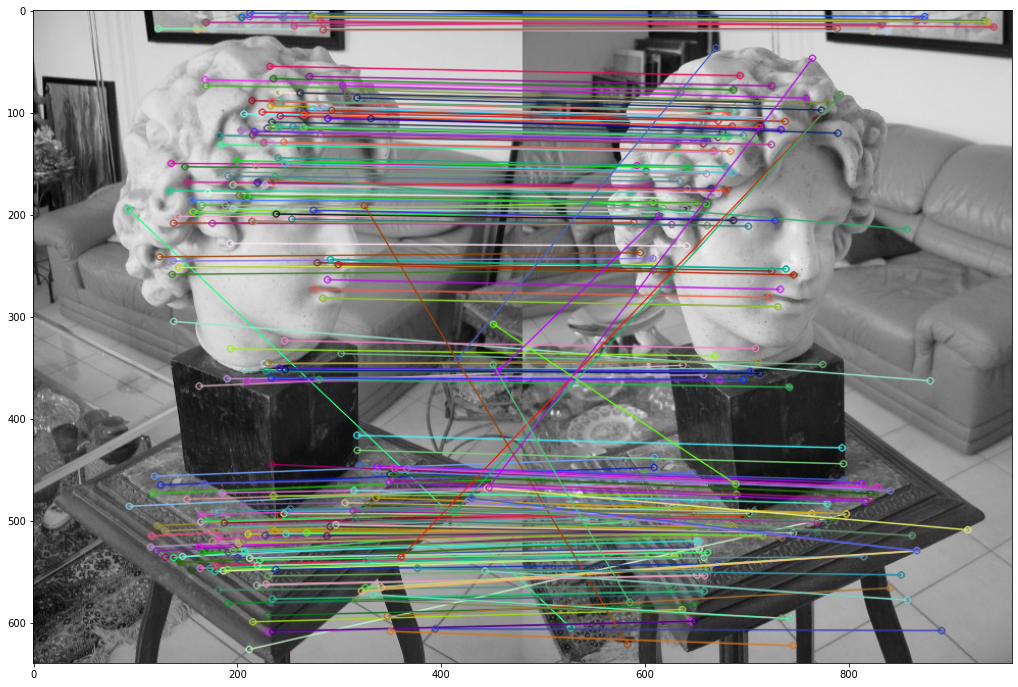

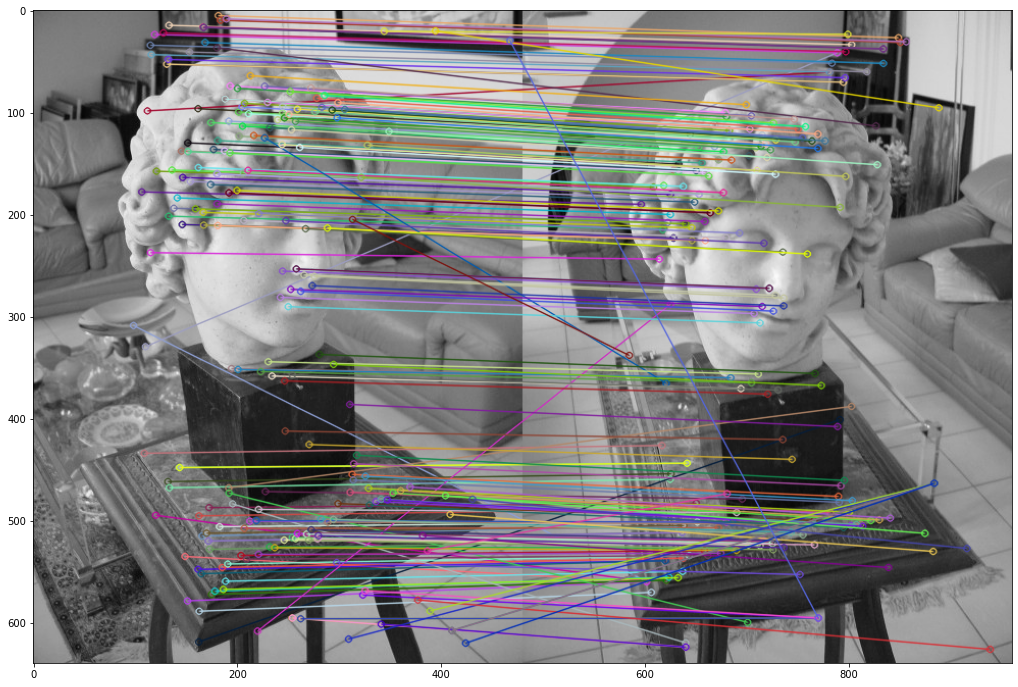

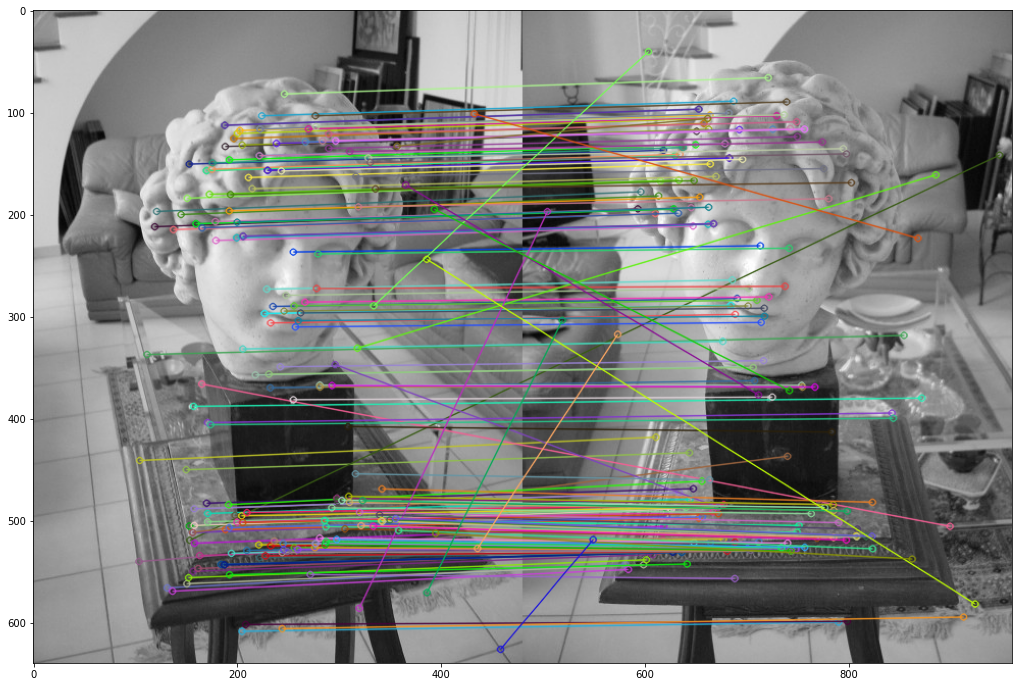

In [8]:
for img in imgs_matched:
    plt.figure(figsize=(20, 12))
    plt.imshow(img)
    plt.show()

In [9]:
focal_length_x = 3278.68
focal_length_y = focal_length_x
principal_point_x = 960
principal_point_y = 540

K = np.array([[focal_length_x, 0, principal_point_x],
              [0, focal_length_y, principal_point_y],
              [0, 0, 1]])
K

array([[3.27868e+03, 0.00000e+00, 9.60000e+02],
       [0.00000e+00, 3.27868e+03, 5.40000e+02],
       [0.00000e+00, 0.00000e+00, 1.00000e+00]])

In [10]:
def rep_error_fn(opt_variables, points_2d, num_pts):
    P = opt_variables[0:12].reshape(3,4)
    point_3d = opt_variables[12:].reshape((num_pts, 4))

    rep_error = []

    for idx, pt_3d in enumerate(point_3d):
        pt_2d = np.array([points_2d[0][idx], points_2d[1][idx]])

        reprojected_pt = np.matmul(P, pt_3d)
        reprojected_pt /= reprojected_pt[2]

        print("Reprojection Error \n" + str(pt_2d - reprojected_pt[0:2]))
        rep_error.append(pt_2d - reprojected_pt[0:2])
    print(len(rep_error))


In [11]:
f_mats = []
e_mats = []
r_mats = []
t_mats = []
R_t_0 = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0]])
R_t_1 = np.empty((3,4))

P1 = np.matmul(K, R_t_0)
P2 = np.empty((3,4))

X = np.array([])
Y = np.array([])
Z = np.array([])

for key, match_ind in flann_good_matches_ind.items():
    pts1 = np.array(match_ind[0])
    pts2 = np.array(match_ind[1])
    
    F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)
    f_mats.append(F)
    print(f"F matrix for {key}:\n {F}\n")
    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]

    
    E = np.matmul(np.matmul(np.transpose(K), F), K)
    e_mats.append(E)
    print(f"E matrix for {key}:\n {E}\n")
    
    
    retval, R, t, mask= cv.recoverPose(E, pts1, pts2, K)
    r_mats.append(R)
    t_mats.append(t)
    
    R_t_1[:3,:3] = np.matmul(R, R_t_0[:3,:3])
    R_t_1[:3, 3] = R_t_0[:3, 3] + np.matmul(R_t_0[:3,:3],t.ravel())
    
    print(f" R_t_0:\n {R_t_0}\n")
    print(f" R_t_1:\n {R_t_1}\n")
    
    P2 = np.matmul(K, R_t_1)
    
    print(f" P1:\n {P1}\n")
    print(f" P2:\n {P2}\n")
    
    pts1 = np.transpose(pts1)
    pts2 = np.transpose(pts2)
    
    points_3d = cv.triangulatePoints(P1, P2, pts1, pts2)
    points_3d /= points_3d[3]
    
    opt_variables = np.hstack((P2.ravel(), points_3d.ravel(order="F")))
    num_points = len(pts2[0])
    rep_error_fn(opt_variables, pts2, num_points)
    
    X = np.concatenate((X, points_3d[0]))
    Y = np.concatenate((Y, points_3d[1]))
    Z = np.concatenate((Z, points_3d[2]))
    
#     R_t_0 = np.copy(R_t_1)
#     P1 = np.copy(P2)
    
    print("\n\n")

F matrix for 1-2:
 [[ 1.54080689e-06  1.96269645e-05 -4.25738047e-03]
 [ 1.38715338e-05 -1.31985458e-06 -1.06513661e-01]
 [ 4.71613947e-03  9.67067503e-02  1.00000000e+00]]

E matrix for 1-2:
 [[  16.56327732  210.9848156    25.64044147]
 [ 149.11541675  -14.18809692 -307.89988892]
 [  44.87182536  376.51021719   14.5454363 ]]

 R_t_0:
 [[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]

 R_t_1:
 [[ 0.55806394 -0.1425411   0.81746356 -0.87209007]
 [ 0.16162426  0.98494     0.06140672 -0.04962564]
 [-0.81390554  0.09785307  0.5726976   0.48682256]]

 P1:
 [[3.27868e+03 0.00000e+00 9.60000e+02 0.00000e+00]
 [0.00000e+00 3.27868e+03 5.40000e+02 0.00000e+00]
 [0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00]]

 P2:
 [[ 1.04836377e+03 -3.73407695e+02  3.22999112e+03 -2.39195461e+03]
 [ 9.04052432e+01  3.28214375e+03  5.10589686e+02  1.00177604e+02]
 [-8.13905542e-01  9.78530689e-02  5.72697604e-01  4.86822563e-01]]

Reprojection Error 
[-0.54571279 22.0667819 ]
Reprojection Error 
[-0.84673248 26.25120785]


<IPython.core.display.Javascript object>


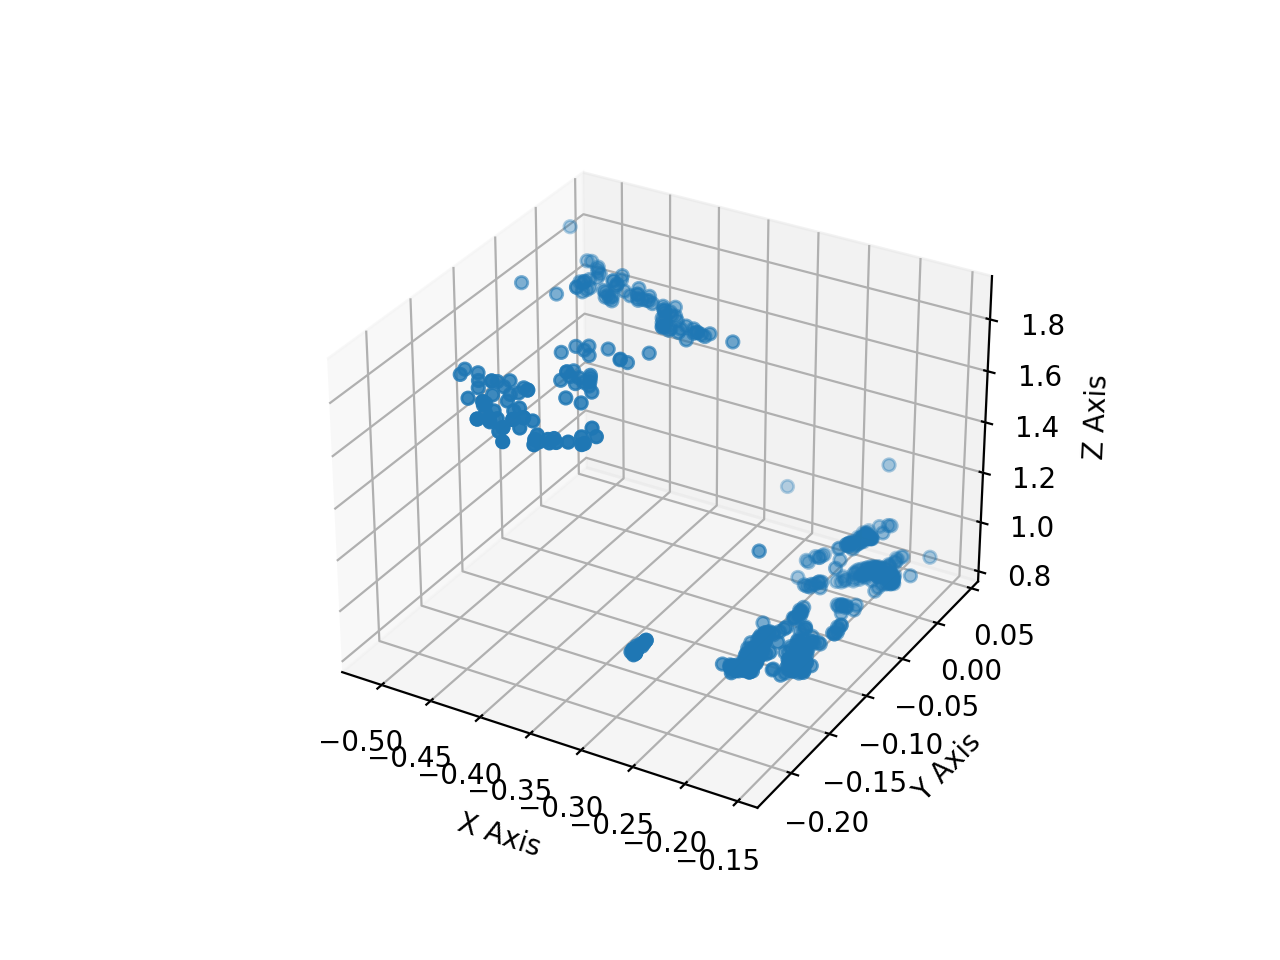

553


In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Sample data (replace with your own X, Y, and Z lists)

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

print(len(X))
# Create the point cloud
ax.scatter(X, Y, Z)

# Set labels for the axes
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Show the plot
plt.show()

In [13]:
f_mats = []
e_mats = []
r_mats = []
t_mats = []
R_t_0 = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0]])
R_t_1 = np.empty((3,4))

P1 = np.matmul(K, R_t_0)
P2 = np.empty((3,4))

X = np.array([])
Y = np.array([])
Z = np.array([])

count = 0
prev_img = None
prev_kp = None
prev_desc = None

for i, img in enumerate(images):
    
    resized_img = img
    
    sift = cv.SIFT_create()
    kp, desc = sift.detectAndCompute(resized_img,None)

    if count == 0:
        prev_img = resized_img
        prev_kp = kp
        prev_desc = desc
    else:
        # FLANN parameters
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks=100)
        flann = cv.FlannBasedMatcher(index_params,search_params)
        matches = flann.knnMatch(prev_desc,desc,k=2)
        good = []
        pts1 = []
        pts2 = []
        # ratio test as per Lowe's paper
        for i,(m,n) in enumerate(matches):
            if m.distance < 0.8*n.distance:
                good.append(m)
                pts1.append(prev_kp[m.queryIdx].pt)
                pts2.append(kp[m.trainIdx].pt)

        pts1 = np.array(pts1)
        pts2 = np.array(pts2)

        F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_RANSAC)
        f_mats.append(F)
        print(f"F matrix for {count}:\n {F}\n")
        pts1 = pts1[mask.ravel()==1]
        pts2 = pts2[mask.ravel()==1]


        E = np.matmul(np.matmul(np.transpose(K), F), K)
        e_mats.append(E)
        print(f"E matrix for {count}:\n {E}\n")


        retval, R, t, mask= cv.recoverPose(E, pts1, pts2, K)
        r_mats.append(R)
        t_mats.append(t)

        R_t_1[:3,:3] = np.matmul(R, R_t_0[:3,:3])
        R_t_1[:3, 3] = R_t_0[:3, 3] + np.matmul(R_t_0[:3,:3],t.ravel())

        print(f" R_t_0:\n {R_t_0}\n")
        print(f" R_t_1:\n {R_t_1}\n")

        P2 = np.matmul(K, R_t_1)

        print(f" P1:\n {P1}\n")
        print(f" P2:\n {P2}\n")

        pts1 = np.transpose(pts1)
        pts2 = np.transpose(pts2)

        points_3d = cv.triangulatePoints(P1, P2, pts1, pts2)
        points_3d /= points_3d[3]

        opt_variables = np.hstack((P2.ravel(), points_3d.ravel(order="F")))
        num_points = len(pts2[0])
        rep_error_fn(opt_variables, pts2, num_points)
        
        X = np.concatenate((X, points_3d[0]))
        Y = np.concatenate((Y, points_3d[1]))
        Z = np.concatenate((Z, points_3d[2]))

        R_t_0 = np.copy(R_t_1)
        P1 = np.copy(P2)
        
        prev_img = resized_img
        prev_kp = kp
        prev_desc = desc

        print("\n\n")
    count += 1

F matrix for 1:
 [[ 7.74985029e-07  2.40259187e-06 -1.00358036e-02]
 [ 5.20419059e-06 -3.00145351e-06 -1.23466680e-01]
 [ 1.54507532e-02  1.16519700e-01  1.00000000e+00]]

E matrix for 1:
 [[   8.33088954   25.82724404  -26.21113967]
 [  55.943709    -32.26485244 -393.74140777]
 [  62.31131922  384.27901223    6.22934107]]

 R_t_0:
 [[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]]

 R_t_1:
 [[ 0.9710414  -0.09008572  0.2212762  -0.99508638]
 [ 0.09983485  0.99444819 -0.03325343  0.06738994]
 [-0.21705206  0.05438153  0.97464406  0.07253757]]

 P1:
 [[3.27868e+03 0.00000e+00 9.60000e+02 0.00000e+00]
 [0.00000e+00 3.27868e+03 5.40000e+02 0.00000e+00]
 [0.00000e+00 0.00000e+00 1.00000e+00 0.00000e+00]]

 P2:
 [[ 2.97536405e+03 -2.43155978e+02  1.66115216e+03 -3.19293374e+03]
 [ 2.10118412e+02  3.28984343e+03  4.17280453e+02  2.60120331e+02]
 [-2.17052062e-01  5.43815297e-02  9.74644064e-01  7.25375684e-02]]

Reprojection Error 
[ 4.79810551 58.98202718]
Reprojection Error 
[ 4.3912093  56.66576244]
Repr

<IPython.core.display.Javascript object>


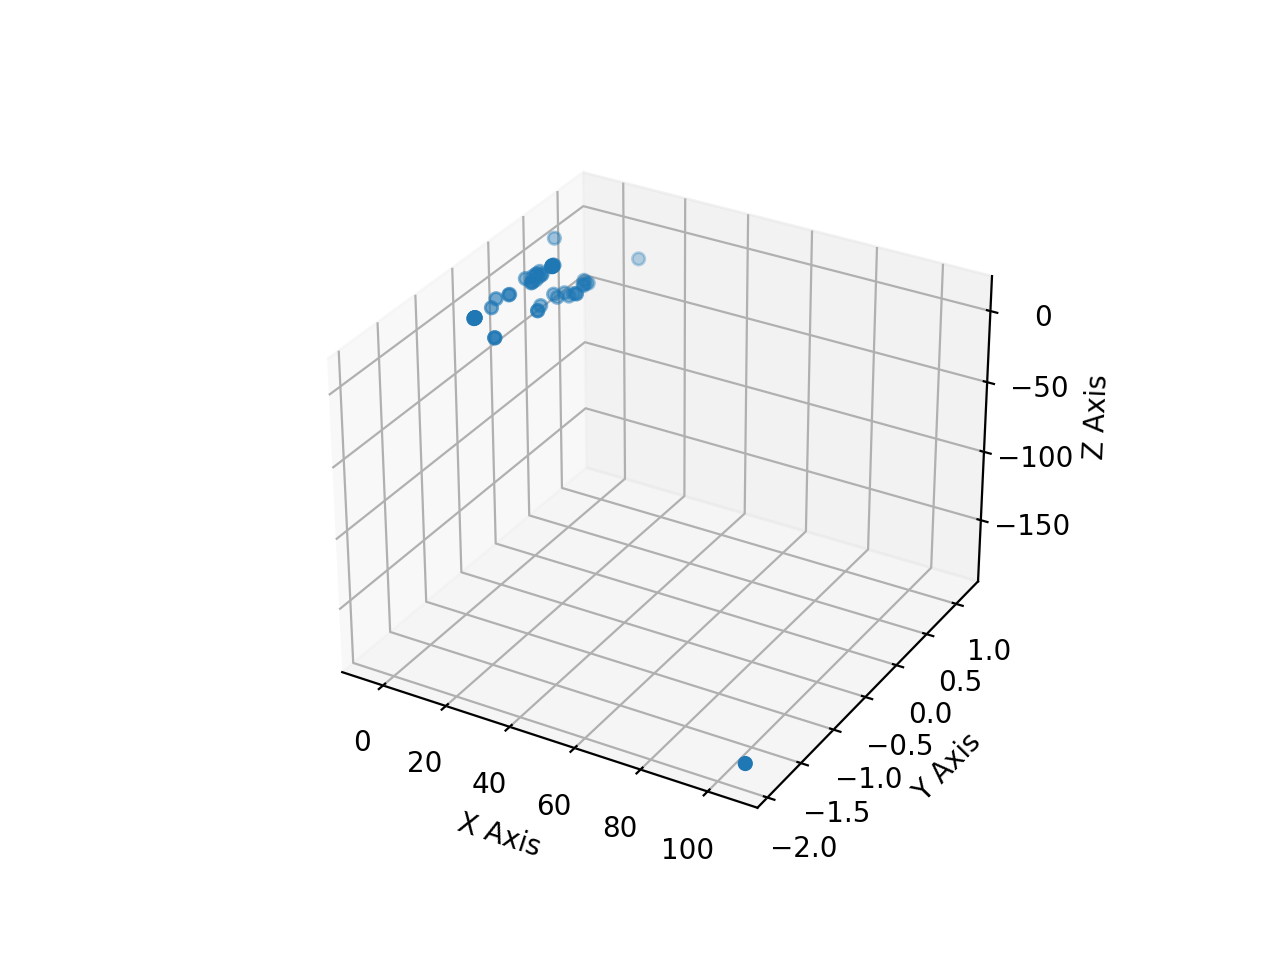

58


In [14]:
# %matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Sample data (replace with your own X, Y, and Z lists)

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
print(len(X))
# Create the point cloud
ax.scatter(X, Y, Z)

# Set labels for the axes
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Show the plot
plt.show()